In [1]:
import glob
import os
import numpy as np
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from GoogletNet import GoogLeNet

In [2]:
# 이미지 불러오기 및 전처리
def load_and_preprocess_images(img_paths, target_size=(224,224)):
    img_array_list = []
    for img_path in img_paths:
        img = np.array(Image.open(tf.io.gfile.GFile(img_path,'rb')).convert('RGB').resize(target_size, Image.BILINEAR), dtype=np.float32)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        img_array_list.append(img)
    return np.vstack(img_array_list)

def create_cav_training_set(concepts, bottleneck, acts):
    x = []
    labels = []
    labels2text = {}
    min_data_points = np.min([acts[concept][bottleneck].shape[0] for concept in acts.keys()])

    for I, concept in enumerate(concepts):
        x.extend(acts[concept][bottleneck][:min_data_points].reshape(min_data_points, -1))
        labels.extend([I] * min_data_points)
        labels2text[I] = concept
    
    x = np.array(x)
    labels = np.array(labels)

    return x, labels, labels2text

def train_lm(lm, x, y, labels2text):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, stratify=y)
    
    lm.fit(x_train, y_train)
    y_pred = lm.predict(x_test)
    
    num_classes = max(y) + 1
    acc = {}
    num_correct = 0
    for class_id in range(num_classes):
        # get indices of all test data that has this class.
        idx = (y_test == class_id)
        acc[labels2text[class_id]] = metrics.accuracy_score(
          y_pred[idx], y_test[idx])
        # overall correctness is weighted by the number of examples in this class.
        num_correct += (sum(idx) * acc[labels2text[class_id]])
    acc['overall'] = float(num_correct) / float(len(y_test))
    tf.compat.v1.logging.info('acc per class %s' % (str(acc)))
    return acc

In [3]:
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
layer_names = ['mixed8', 'mixed9', 'mixed10']
target_class_names = ['zebra']
concept_names = ['striped']
random_concept_names = ['random1', 'random2', 'random3']
concept_pairs = []

for c in concept_names:
    for rc in random_concept_names:
        concept_pairs.append([c, rc])

layer_outputs = [model.get_layer(name).output for name in layer_names]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [4]:
input_imgs = {}
concepts = {}
randoms = {}

target_path = glob.glob('test_data/zebra/*')
concept_path = glob.glob('test_data/striped/*')
random_paths = [
    glob.glob('test_data/random1/*'),
    glob.glob('test_data/random2/*'),
    glob.glob('test_data/random3/*')
]

target_imgs = load_and_preprocess_images(target_path, target_size=(299,299))
concept_imgs = load_and_preprocess_images(concept_path, target_size=(299,299))
random_imgs = [load_and_preprocess_images(paths, target_size=(299,299)) for paths in random_paths]

concepts['zebra'] = target_imgs 
concepts['striped'] = concept_imgs
input_imgs['concepts'] = concepts

for i, random_img in enumerate(random_imgs):
    randoms[f'random{i+1}'] = random_img

input_imgs['randoms'] = randoms

In [5]:
for k in input_imgs.keys():
    for k2 in input_imgs[k].keys():
        activations = activation_model.predict(input_imgs[k][k2])
        for i, act in enumerate(activations):
            np.save(f'./acts_inceptionv3/{k2}_{layer_names[i]}', act, allow_pickle=False)

In [6]:
# 딕셔너리 초기화
acts = {}

# 파일 불러와서 딕셔너리에 저장
for file_path in glob.glob('./acts_inceptionv3/*'):
    # 파일 이름에서 concept와 layer 추출
    file_name = os.path.basename(file_path)
    parts = file_name.split('_')
    concept = parts[0]
    layer = parts[1].replace('.npy', '')
    
    # 데이터 불러오기
    data = np.load(file_path)
    
    # 딕셔너리에 저장
    if concept not in acts:
        acts[concept] = {}
    acts[concept][layer] = data

# 결과 확인
for concept, layers in acts.items():
    for layer, data in layers.items():
        print(f"Concept: {concept}, Layer: {layer}, Data shape: {data.shape}")

Concept: random1, Layer: mixed10, Data shape: (44, 8, 8, 2048)
Concept: random1, Layer: mixed8, Data shape: (44, 8, 8, 1280)
Concept: random1, Layer: mixed9, Data shape: (44, 8, 8, 2048)
Concept: random2, Layer: mixed10, Data shape: (42, 8, 8, 2048)
Concept: random2, Layer: mixed8, Data shape: (42, 8, 8, 1280)
Concept: random2, Layer: mixed9, Data shape: (42, 8, 8, 2048)
Concept: random3, Layer: mixed10, Data shape: (40, 8, 8, 2048)
Concept: random3, Layer: mixed8, Data shape: (40, 8, 8, 1280)
Concept: random3, Layer: mixed9, Data shape: (40, 8, 8, 2048)
Concept: striped, Layer: mixed10, Data shape: (50, 8, 8, 2048)
Concept: striped, Layer: mixed8, Data shape: (50, 8, 8, 1280)
Concept: striped, Layer: mixed9, Data shape: (50, 8, 8, 2048)
Concept: zebra, Layer: mixed10, Data shape: (37, 8, 8, 2048)
Concept: zebra, Layer: mixed8, Data shape: (37, 8, 8, 1280)
Concept: zebra, Layer: mixed9, Data shape: (37, 8, 8, 2048)


In [38]:
cavs = {}

for layer_name in layer_names:
    cavs[layer_name] = {}
    for concept_pair in concept_pairs:
        x, labels, labels2text = create_cav_training_set(concept_pair, layer_name, acts)
        lm = linear_model.SGDClassifier(alpha=0.1, max_iter=1000, tol=1e-3)
        acc = train_lm(lm, x, labels, labels2text)
        cav = [-1*lm.coef_[0], lm.coef_[0]]
        cavs[layer_name][concept_pair[0]]= cav

INFO:tensorflow:acc per class {'striped': 1.0, 'random1': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random2': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random3': 0.9166666666666666, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 1.0, 'random1': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 0.75, 'random2': 1.0, 'overall': 0.88}
INFO:tensorflow:acc per class {'striped': 1.0, 'random3': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random1': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random2': 0.9166666666666666, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 1.0, 'random3': 1.0, 'overall': 1.0}


In [36]:
x, labels, labels2text = create_cav_training_set(concept_pairs[0], 'mixed8', acts)
lm = linear_model.SGDClassifier(alpha=0.1, max_iter=1000, tol=1e-3)
acc = train_lm(lm, x, labels, labels2text)
cavs = [-1*lm.coef_[0], lm.coef_[0]]

INFO:tensorflow:acc per class {'striped': 1.0, 'random1': 1.0, 'overall': 1.0}


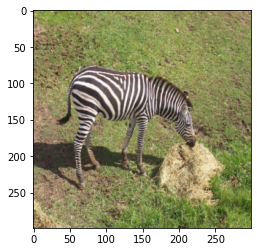

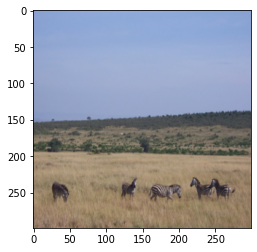

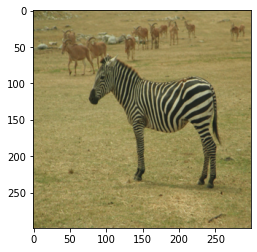

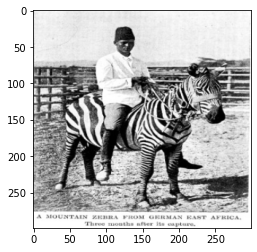

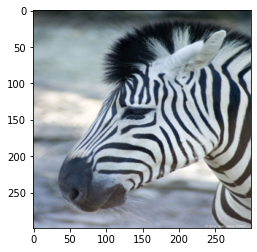

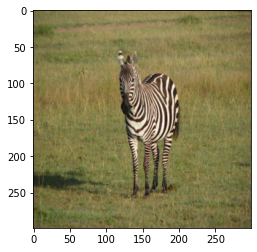

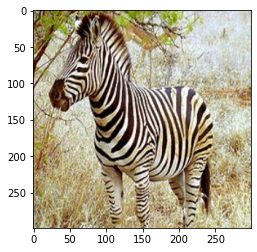

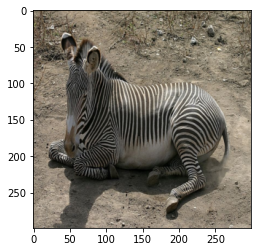

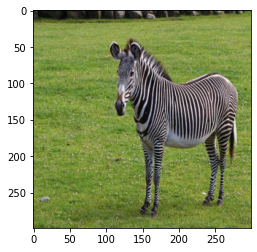

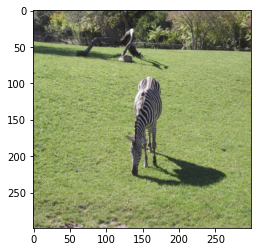

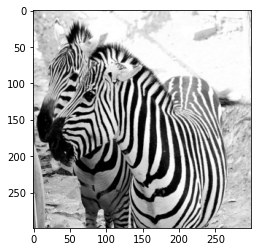

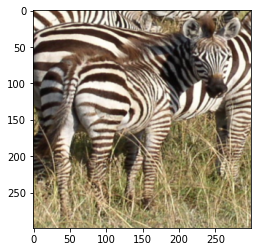

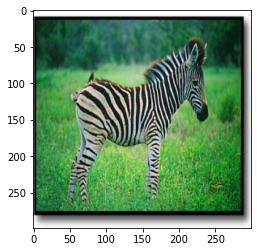

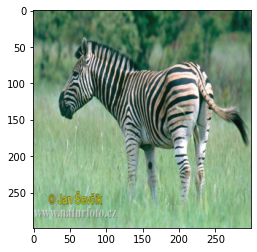

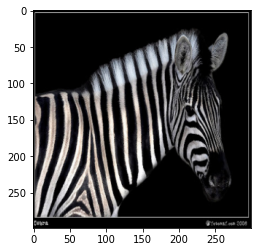

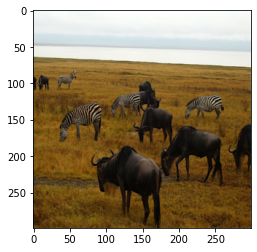

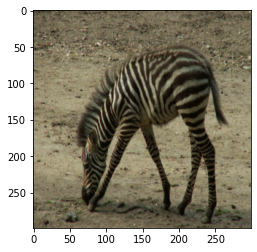

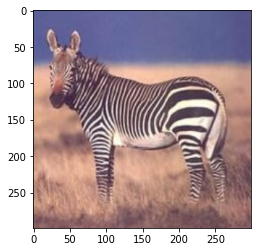

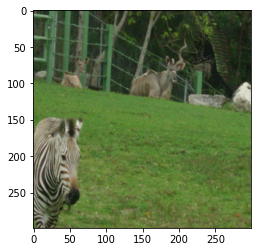

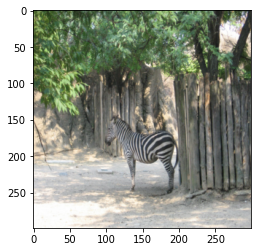

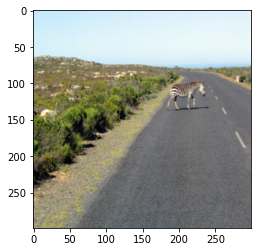

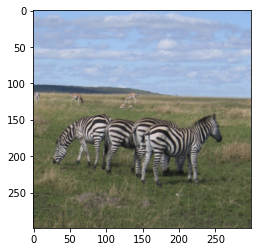

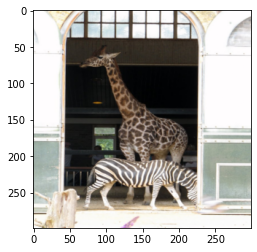

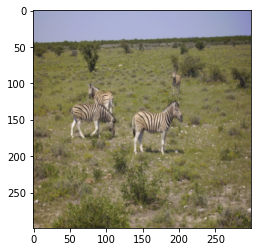

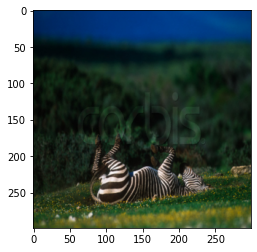

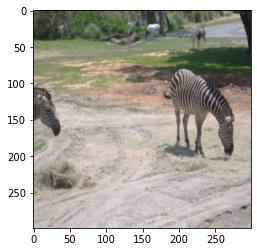

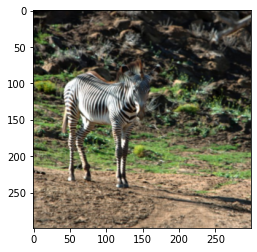

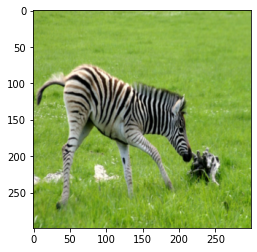

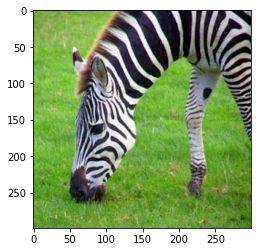

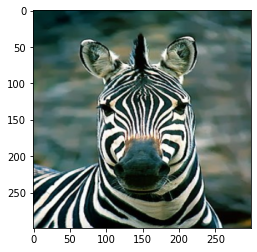

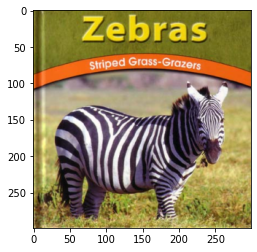

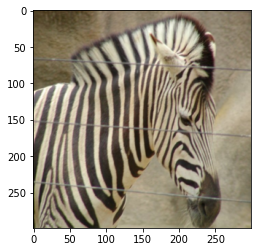

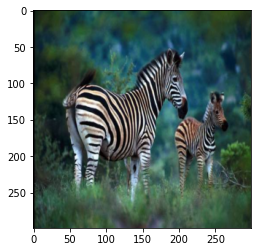

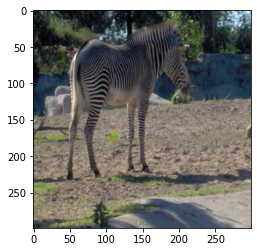

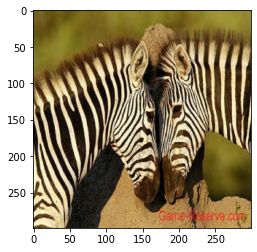

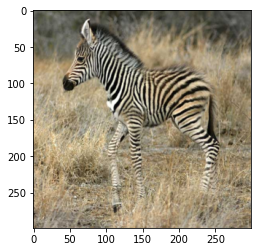

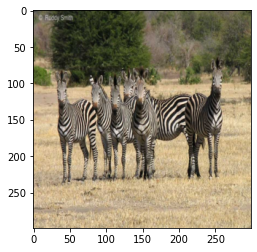

In [15]:
for img in input_imgs['concepts']['zebra']:
    plt.imshow(img)
    plt.show()

In [29]:
layer_gradients = {}

for layer_name in layer_names:
    img = tf.convert_to_tensor(input_imgs['concepts']['zebra'])

    with tf.GradientTape() as tape:
        tape.watch(img)
        logits_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
        layer_act, logits = logits_model(img)
        selected_logit = logits[:, 340]

    gradient = tape.gradient(selected_logit, layer_act)

    if grads is None:
        raise ValueError("Gradient computation returned None. Ensure the input tensor is correctly tracked.")
    layer_gradients[layer_name] = gradient

In [73]:
cs = {}
for layer_name in layer_names:
    cs[layer_name] = []
    for grad in layer_gradients[layer_name]:
        cs[layer_name].append(np.dot(np.reshape(grad,-1), cavs[layer_name]['striped'][0]))

In [77]:
cs['mixed8']

[-0.0005039899455295138,
 0.0010394801091955911,
 0.005044989365074529,
 0.0006734873720755693,
 -0.005010112214964055,
 -0.001812408356527157,
 0.002486588696654803,
 -0.0007411184984133074,
 0.00029573265345075243,
 -0.0013562725502243337,
 0.0032300800415518477,
 -0.000952184759166682,
 -0.001625915891264268,
 0.002005622570710153,
 -0.000867304748516961,
 0.023132893780822242,
 -0.003220909948760209,
 -0.0017929555391431875,
 0.012313550012639177,
 0.0012197157734739812,
 0.007375407629366526,
 -0.0008743582424850985,
 0.012847507537828953,
 -0.0019584973579531697,
 0.0006461193861403787,
 0.005601868648995138,
 -0.00042998415210368957,
 -0.006325598375338653,
 -0.0071965014132944725,
 -0.009506881241686653,
 0.004013718678190321,
 0.0004471766359379068,
 -0.002664349259303484,
 0.0036171561211742463,
 0.0027690191056690006,
 0.0006729282464758899,
 0.0022159925150185126]

TCAV score

In [74]:
for layer_name in layer_names:
    print(layer_name)
    print(sum(1 for num in cs[layer_name] if num > 0)/len(cs[layer_name]))

mixed8
0.5405405405405406
mixed9
1.0
mixed10
1.0
